In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-experience-dataset/customer_experience_data.csv


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

## 1. Data Exploration and Preprocessing

In [6]:
# Set random seed for reproductibility
np.random.seed(42)

In [4]:
# Load the data and display basic info and first 5 entries
df = pd.read_csv('/kaggle/input/customer-experience-dataset/customer_experience_data.csv')
print("\nDataset Info:")
print(df.info())
print("\nFiirst 5 entries:")
df.head()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               1000 non-null   int64  
 1   Age                       1000 non-null   int64  
 2   Gender                    1000 non-null   object 
 3   Location                  1000 non-null   object 
 4   Num_Interactions          1000 non-null   int64  
 5   Feedback_Score            1000 non-null   int64  
 6   Products_Purchased        1000 non-null   int64  
 7   Products_Viewed           1000 non-null   int64  
 8   Time_Spent_on_Site        1000 non-null   float64
 9   Satisfaction_Score        1000 non-null   int64  
 10  Retention_Status          1000 non-null   object 
 11  Gender_Encoded            1000 non-null   int64  
 12  Location_Encoded          1000 non-null   int64  
 13  Retention_Status_Encoded  1000 non-null   int64  

,Customer_ID,Age,Gender,Location,Num_Interactions,Feedback_Score,Products_Purchased,Products_Viewed,Time_Spent_on_Site,Satisfaction_Score,Retention_Status,Gender_Encoded,Location_Encoded,Retention_Status_Encoded
0,1,56,Male,Urban,11,4,18,38,18.319606,7,Retained,1,2,1
1,2,69,Male,Suburban,10,3,2,17,9.015198,6,Retained,1,1,1
2,3,46,Male,Urban,5,5,11,46,45.921572,10,Churned,1,2,0
3,4,32,Female,Suburban,5,1,6,13,44.105053,5,Churned,0,1,0
4,5,60,Male,Urban,14,5,8,46,17.897471,1,Retained,1,2,1


In [5]:
# Check missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Customer_ID                 0
Age                         0
Gender                      0
Location                    0
Num_Interactions            0
Feedback_Score              0
Products_Purchased          0
Products_Viewed             0
Time_Spent_on_Site          0
Satisfaction_Score          0
Retention_Status            0
Gender_Encoded              0
Location_Encoded            0
Retention_Status_Encoded    0
dtype: int64


In [7]:
# Summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
       Customer_ID         Age  Num_Interactions  Feedback_Score  \
count  1000.000000  1000.00000       1000.000000     1000.000000   
mean    500.500000    43.81900          7.545000        2.985000   
std     288.819436    14.99103          4.016978        1.418022   
min       1.000000    18.00000          1.000000        1.000000   
25%     250.750000    31.00000          4.000000        2.000000   
50%     500.500000    44.00000          8.000000        3.000000   
75%     750.250000    56.00000         11.000000        4.000000   
max    1000.000000    69.00000         14.000000        5.000000   

       Products_Purchased  Products_Viewed  Time_Spent_on_Site  \
count         1000.000000      1000.000000         1000.000000   
mean            10.417000        27.370000           32.274399   
std              5.345623        12.939572           15.734978   
min              1.000000         5.000000            5.114208   
25%              6.000000        17.

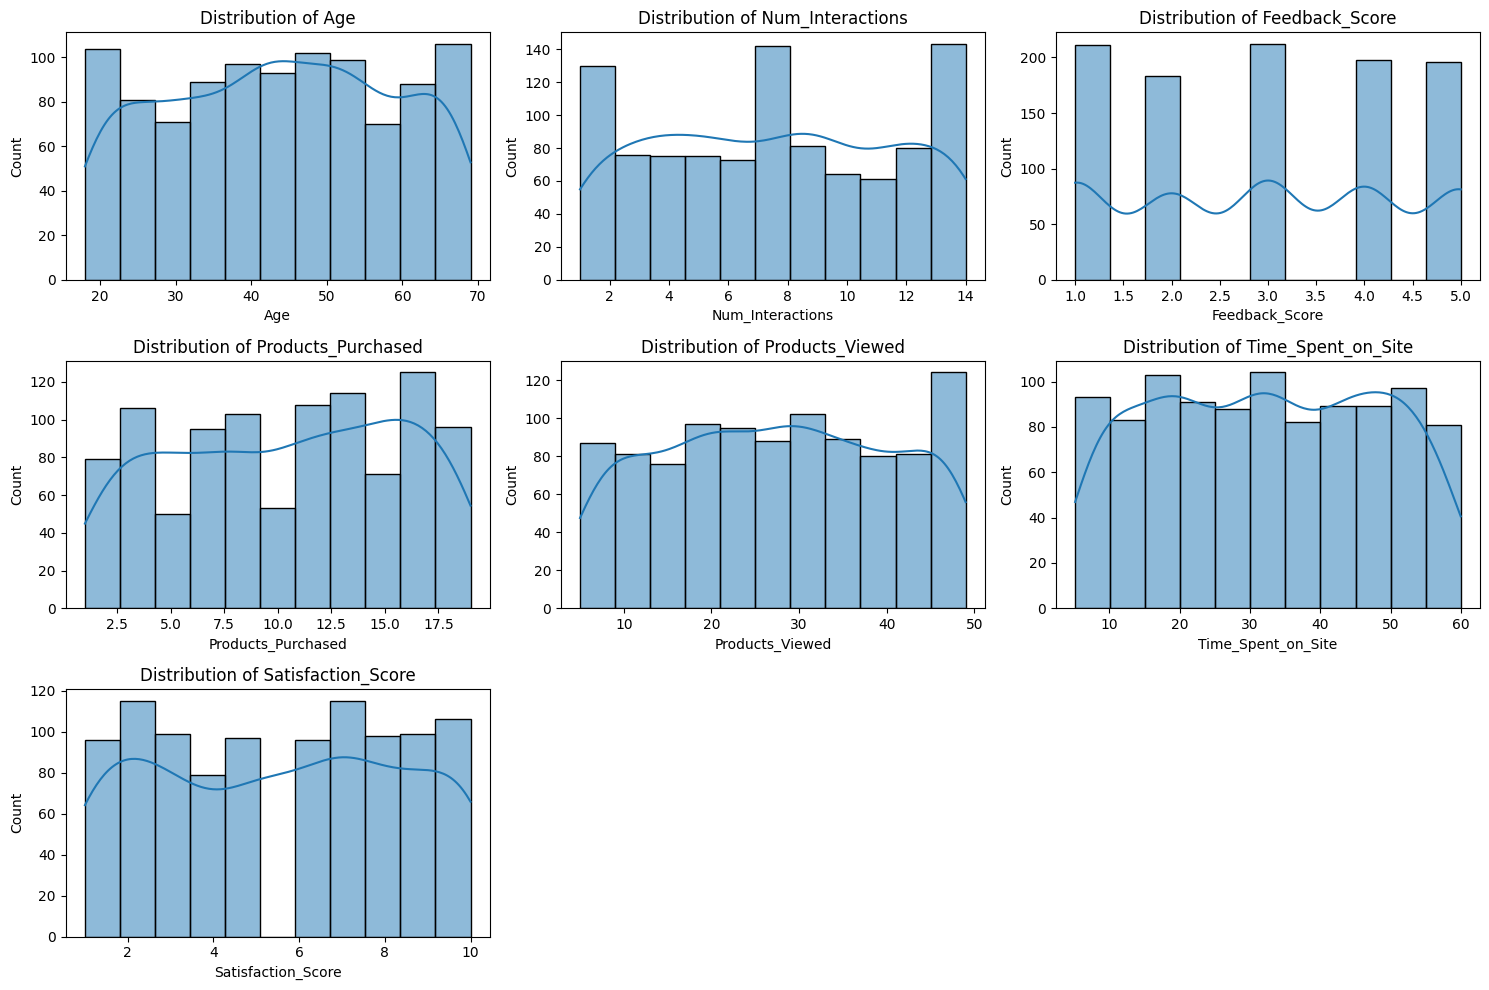

In [11]:
# Visualize distributions of numerical features
numerical_cols = ['Age', 'Num_Interactions', 'Feedback_Score', 'Products_Purchased', 
                  'Products_Viewed', 'Time_Spent_on_Site', 'Satisfaction_Score']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

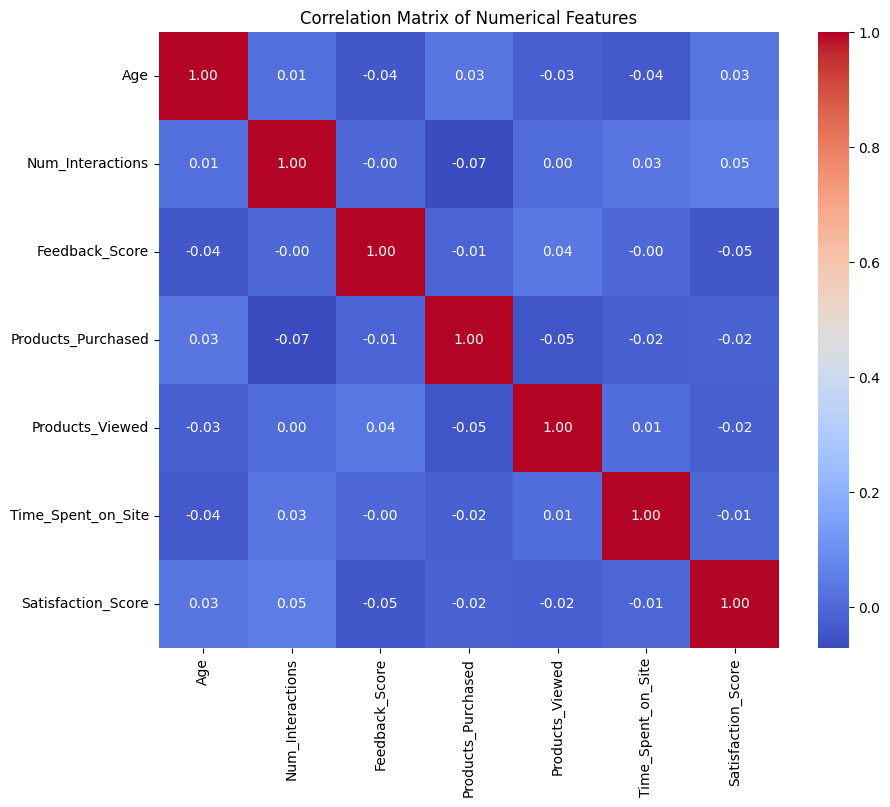

In [12]:
# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [13]:
# Check categorical encoded columns
encoded_cols = ['Gender_Encoded', 'Location_Encoded', 'Retention_Status_Encoded']
print("\nValue Counts for Encoded Columns:")
for col in encoded_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())


Value Counts for Encoded Columns:

Gender_Encoded:
Gender_Encoded
1    524
0    476
Name: count, dtype: int64

Location_Encoded:
Location_Encoded
2    344
1    344
0    312
Name: count, dtype: int64

Retention_Status_Encoded:
Retention_Status_Encoded
1    694
0    306
Name: count, dtype: int64


In [14]:
# Preprocessing: Select features for clustering (exclude Customer_ID and Retention_Status)
features = ['Age', 'Num_Interactions', 'Feedback_Score', 'Products_Purchased', 
            'Products_Viewed', 'Time_Spent_on_Site', 'Satisfaction_Score', 
            'Gender_Encoded', 'Location_Encoded']
X = df[features].copy()

# Create a copy of the DataFrame for hyperparameter tuning
X_tuning = X.copy()

In [15]:
# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [16]:
# Verify scaled data
print("\nScaled Data (First 5 Rows):")
print(X.head())


Scaled Data (First 5 Rows):
        Age  Num_Interactions  Feedback_Score  Products_Purchased  \
0  0.812959          0.860530        0.716144            1.419254   
1  1.680578          0.611462        0.010583           -1.575347   
2  0.145560         -0.633878        1.421705            0.109116   
3 -0.788799         -0.633878       -1.400538           -0.826697   
4  1.079919          1.607734        1.421705           -0.452372   

   Products_Viewed  Time_Spent_on_Site  Satisfaction_Score  Gender_Encoded  \
0         0.821922           -0.887308            0.502958               1   
1        -0.801819           -1.478924            0.158466               1   
2         1.440490            0.867748            1.536434               1   
3        -1.111102            0.752246           -0.186026               0   
4         1.440490           -0.914149           -1.563993               1   

   Location_Encoded  
0                 2  
1                 1  
2                 2  

#### **Analysis of Results**

**1. Summary Statistics:**

- **Age:** Mean age is 43.82 years with a standard deviation of 14.99, ranging from 18 to 69. The distribution is fairly wide, suggesting a diverse customer base.
- **Num_Interactions:** Mean is 7.55 with a standard deviation of 4.02, ranging from 1 to 14. The median (8) is close to the mean, indicating a relatively symmetric distribution.
- **Feedback_Score:** Mean is 2.99 (on a 1-5 scale), with a standard deviation of 1.42. The median (3) aligns with the mean, suggesting no extreme skew.
- **Products_Purchased:** Mean is 10.42, ranging from 1 to 19. The median (11) is close to the mean, indicating a balanced distribution.
- **Products_Viewed:** Mean is 27.37, with a standard deviation of 12.94, ranging from 5 to 49. The median (27.5) is nearly identical to the mean, suggesting symmetry.
- **Time_Spent_on_Site:** Mean is 32.27 minutes, with a standard deviation of 15.73, ranging from 5.11 to 59.95. The median (32.46) is close to the mean, indicating a symmetric distribution.
- **Satisfaction_Score:** Mean is 5.54 (on a 1-10 scale), with a standard deviation of 2.90. The median (6) is slightly higher than the mean, suggesting a slight left skew (more lower scores).
- **Encoded Columns:**
    - **Gender_Encoded:** 52.4% male, 47.6% female, fairly balanced.
    - **Location_Encoded:** Roughly evenly split (344 Urban, 344 Suburban, 312 Rural), which implies no dominant location type.
    - **Retention_Status_Encoded:** 69.4% retained, 30.6% churned, indicates a class imbalance if used in supervised learning but not relevant for clustering so not important to this project.
      
**2. Numerical Features Distributions:**

- **Age:** The distribution is bimodal, with peaks around 30 and 55 years. This means that there are two distinct age groups (younger and older customers).
- **Num_Interactions:** Slightly right-skewed, with a peak around 4-6 interactions. Most customers interact 4-12 times, with fewer having very low or very high interactions.
- **Feedback_Score:** Discrete values (1-5), with a peak at 3. The distribution is roughly symmetric, with fewer customers giving extreme scores (1 or 5).
- **Products_Purchased:** Slightly right-skewed, with a peak around 5-7. Most customers purchase 5-15 products, with fewer purchasing very few (1-4) or many (16-19).
- **Products_Viewed:** Fairly symmetric, with a peak around 25-30. Most customers view 15-40 products, with fewer at the extremes (5 or 49).
Time_Spent_on_Site: Bimodal, with peaks around 15-20 and 45-50 minutes. This suggests two distinct behaviors: quick visits and longer engagements.
- **Satisfaction_Score:** Slightly left-skewed, with peaks at 3 and 7-8. Most scores are between 3-8, with fewer customers extremely dissatisfied (1-2) or extremely satisfied (10).

**3. Correlation Matrix:**

- Most correlations are very weak (close to 0), which indicates low linear relationships between numerical features, which is ideal for clustering as it reduces redundancy.
- **Notable Correlations:**
    - **Num_Interactions and Products_Purchased (-0.07):** A very weak negative correlation, suggesting that more interactions don’t necessarily lead to more purchases.
    - **Products_Purchased and Products_Viewed (-0.05):** A weak negative correlation, indicating that viewing more products doesn’t strongly correlate with purchasing more.
- No strong multicollinearity (e.g., correlations > 0.7), so all numerical features can be retained for clustering without dimensionality reduction for collinearity reasons.

**4. Potential Issues and Observations:**

- Bimodal distributions (Age, Time_Spent_on_Site) suggest natural groupings in the data, which clustering should capture (e.g., younger vs. older customers, quick vs. long visits).
- Slight skewness in some features (e.g., Num_Interactions, Satisfaction_Score) may affect clustering algorithms like K-Means, which assume spherical clusters. We may explore alternatives like Gaussian Mixture Models (GMM) if needed.
- Low correlations indicate that features are relatively independent, which is good for clustering but may make it harder to find strong, distinct clusters if patterns are subtle.
- No missing values or outliers based on summary statistics and histograms.

## 2. Feature Selection and Engineering

In [18]:
# Check feature variance to identify low-variance features
selector = VarianceThreshold(threshold=0.01)  # Remove features with variance < 0.01
X_variance = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()]
print("Features after variance threshold:", selected_features)

Features after variance threshold: Index(['Age', 'Num_Interactions', 'Feedback_Score', 'Products_Purchased',
       'Products_Viewed', 'Time_Spent_on_Site', 'Satisfaction_Score',
       'Gender_Encoded', 'Location_Encoded'],
      dtype='object')


In [19]:
# If any features are removed, update X
X = X[selected_features].copy()

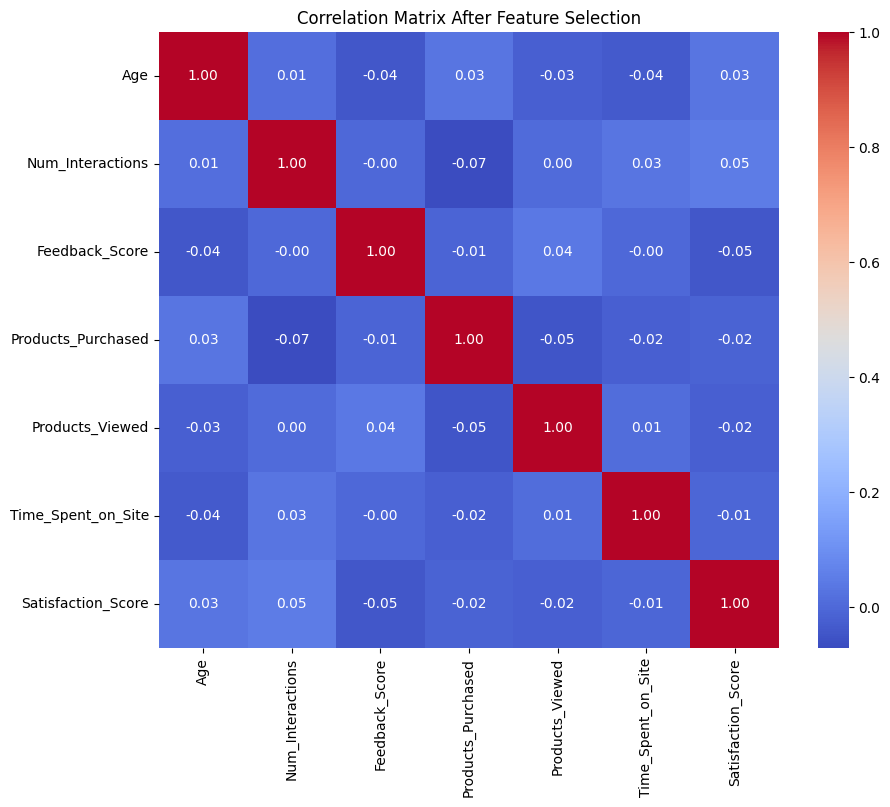

In [20]:
# Recheck correlations after feature selection (for selected numerical features)
numerical_cols_updated = [col for col in numerical_cols if col in selected_features]
if numerical_cols_updated:
    plt.figure(figsize=(10, 8))
    sns.heatmap(X[numerical_cols_updated].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix After Feature Selection')
    plt.show()

In [21]:
# Apply PCA for visualization (2 components) and potential dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [22]:
# Explained variance ratio
print("Explained Variance Ratio of PCA Components:", pca.explained_variance_ratio_)
print("Total Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance Ratio of PCA Components: [0.14287399 0.13965097]
Total Explained Variance: 0.28252495154464663


#### **Analyysis of Results**

The first two PCA components explain 14.29% and 13.97% of the variance, respectively, for a total of 28.25%. For now, we’ll proceed with clustering on the full feature set (X) to preserve all information. After clustering, we’ll revisit visualization using t-SNE or a higher number of PCA components to better represent the clusters.

## 3. Clustering

In [25]:
# Elbow method to determine optimal number of clusters for K-Means
inertia = []
silhouette_scores = []
K = range(2, 11)  # Test 2 to 10 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    if k > 1:  # Silhouette score requires at least 2 clusters
        score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(0)  # Placeholder for k=1 (not used)

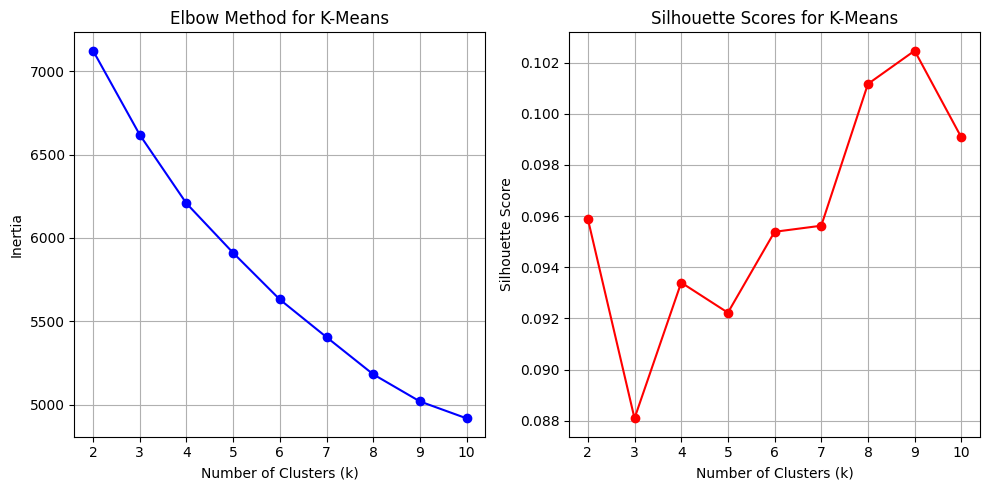

In [26]:
# Plot Elbow Curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means')
plt.grid(True)

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for K-Means')
plt.grid(True)

plt.tight_layout()
plt.show()

The elbow point where the rate of decrease in inertia slows significantly appears to be around k=4. The local peak of the silhouette score plot at k=4 (0.096) supports our choice of k=4.

In [27]:
# Select optimal k based on elbow and silhouette
optimal_k = 4  
print(f"Selected number of clusters for K-Means: {optimal_k}")

Selected number of clusters for K-Means: 4


In [28]:
# Fit K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
kmeans_silhouette = silhouette_score(X, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette}")

K-Means Silhouette Score: 0.09340126540652294


In [29]:
# Fit Gaussian Mixture Model (GMM) with same number of clusters
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = gmm.fit_predict(X)
gmm_silhouette = silhouette_score(X, gmm_labels)
print(f"GMM Silhouette Score: {gmm_silhouette}")

GMM Silhouette Score: 0.07142224129878086


In [30]:
# Add cluster labels to the original DataFrame for analysis
df['KMeans_Cluster'] = kmeans_labels
df['GMM_Cluster'] = gmm_labels

In [31]:
# Summary of clusters
print("\nK-Means Cluster Sizes:")
print(df['KMeans_Cluster'].value_counts())
print("\nGMM Cluster Sizes:")
print(df['GMM_Cluster'].value_counts())


K-Means Cluster Sizes:
KMeans_Cluster
1    269
3    257
2    239
0    235
Name: count, dtype: int64

GMM Cluster Sizes:
GMM_Cluster
0    329
1    280
3    241
2    150
Name: count, dtype: int64


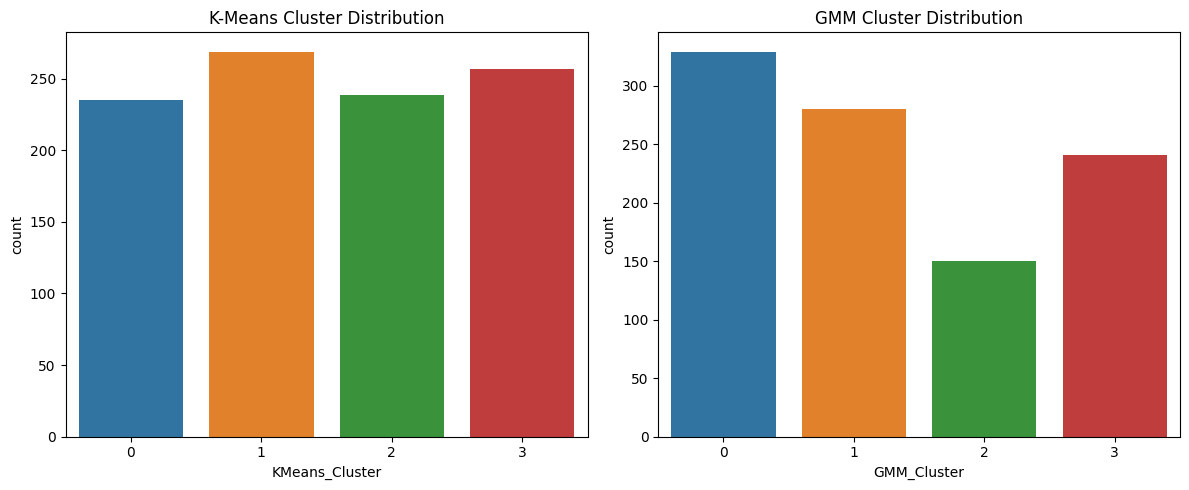

In [32]:
# Visualize cluster distribution (bar plot)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='KMeans_Cluster', data=df)
plt.title('K-Means Cluster Distribution')
plt.subplot(1, 2, 2)
sns.countplot(x='GMM_Cluster', data=df)
plt.title('GMM Cluster Distribution')
plt.tight_layout()
plt.show()

#### **Analysis of Results**

**1. Comparison of K-Means and GMM:**

- **Silhouette Scores:** K-Means (0.0934) outperforms GMM (0.0714), indicating better cluster cohesion and separation. While both scores are low, K-Means appears to better capture the underlying structure of the data.
- **Cluster Balance:** K-Means produces more balanced clusters (235–269) compared to GMM (150–329). Balanced clusters are preferable for interpretability and practical use, as they ensure each segment is substantial enough for targeted actions.
- **Algorithm Suitability:** K-Means assumes spherical clusters and equal variance, which may align better with this dataset given the relatively symmetric distributions of most features (e.g., Age, Products_Viewed). GMM, which allows for elliptical clusters and varying covariance, might be overfitting or struggling due to the lack of strong, non-spherical patterns in the data, as evidenced by the low silhouette score.
- **Recommendation:** Based on the higher silhouette score and more balanced clusters, K-Means with k=4 is the better model for this dataset. We’ll proceed with K-Means clusters for the next section (cluster analysis and interpretation) and discard the GMM results.

**2. Additional Observations:**

- The low silhouette scores for both models (0.0934 for K-Means, 0.0714 for GMM) suggest that the data may not have strong, natural clusters. This aligns with earlier findings: the PCA explained variance was low (28.25% for 2 components), and correlations between features were weak, indicating that the data’s structure is diffuse.
- Despite the low silhouette scores, K-Means with k=4 provides a practical segmentation that can still yield actionable insights, especially given the balanced cluster sizes.
- The GMM’s poorer performance may be due to its sensitivity to initialization or the dataset’s lack of elliptical cluster shapes. If desired, we could explore additional clustering algorithms (e.g., DBSCAN for density-based clustering) in future iterations, but K-Means is sufficient for now.

## 4. Cluster Analysis and Interpretation

In [33]:
# Note: We excluded Retention_Status and Customer_ID from clustering, but we can include them for interpretation
cluster_features = ['Age', 'Num_Interactions', 'Feedback_Score', 'Products_Purchased', 
                   'Products_Viewed', 'Time_Spent_on_Site', 'Satisfaction_Score', 
                   'Gender_Encoded', 'Location_Encoded', 'Retention_Status_Encoded']

In [34]:
# Group by K-Means clusters and compute mean for each feature
cluster_summary = df.groupby('KMeans_Cluster')[cluster_features].mean()
print("Cluster Summary (Mean Values):")
print(cluster_summary)

Cluster Summary (Mean Values):
                      Age  Num_Interactions  Feedback_Score  \
KMeans_Cluster                                                
0               45.314894         11.204255        1.859574   
1               48.193309          4.513011        2.211896   
2               43.167364         10.297071        4.305439   
3               38.478599          4.813230        3.595331   

                Products_Purchased  Products_Viewed  Time_Spent_on_Site  \
KMeans_Cluster                                                            
0                         7.702128        26.165957           34.286198   
1                        14.546468        23.427509           30.313436   
2                        12.794979        26.870293           33.932260   
3                         6.365759        33.062257           30.945596   

                Satisfaction_Score  Gender_Encoded  Location_Encoded  \
KMeans_Cluster                                                     

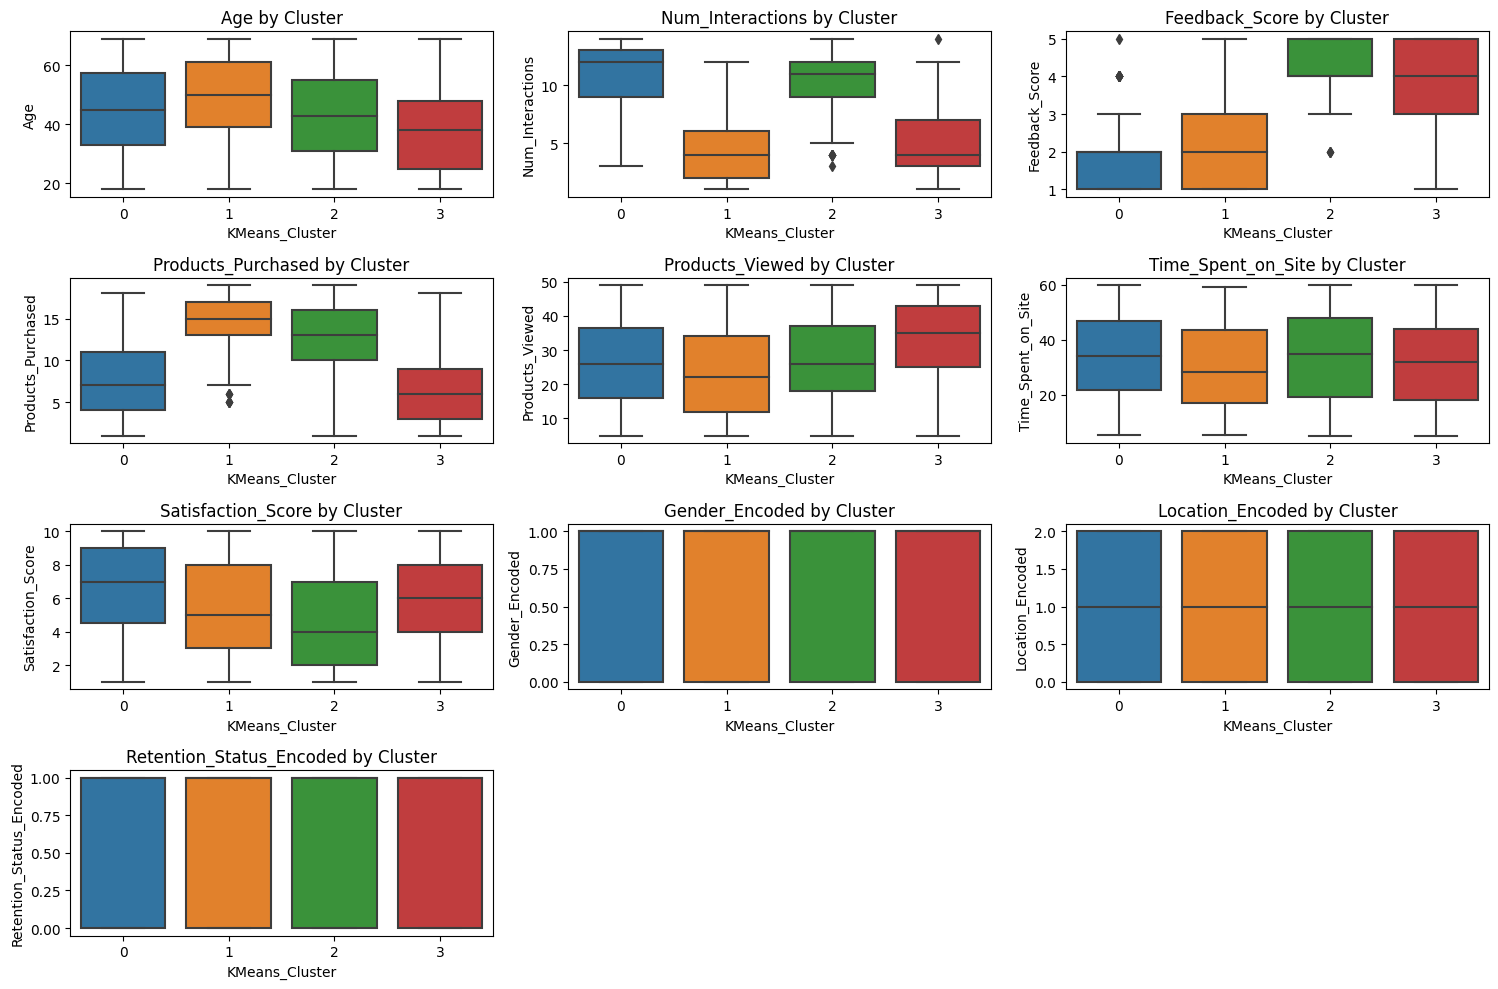

In [35]:
# Visualize feature distributions across clusters using box plots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(cluster_features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='KMeans_Cluster', y=feature, data=df)
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.show()

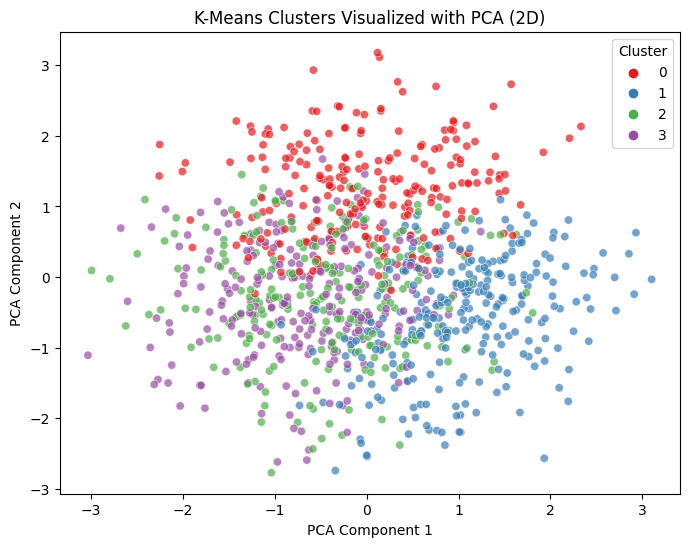

In [36]:
# Visualize clusters in 2D using PCA (despite low explained variance, for illustration)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='Set1', data=df, alpha=0.7)
plt.title('K-Means Clusters Visualized with PCA (2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [37]:
# Business interpretation 
print("\nBusiness Interpretation:")
for cluster in range(4):
    print(f"\nCluster {cluster}:")
    print(f"- Average Age: {cluster_summary.loc[cluster, 'Age']:.1f}")
    print(f"- Average Num_Interactions: {cluster_summary.loc[cluster, 'Num_Interactions']:.1f}")
    print(f"- Average Satisfaction_Score: {cluster_summary.loc[cluster, 'Satisfaction_Score']:.1f}")
    print(f"- Retention Rate: {cluster_summary.loc[cluster, 'Retention_Status_Encoded']:.2f}")


Business Interpretation:

Cluster 0:
- Average Age: 45.3
- Average Num_Interactions: 11.2
- Average Satisfaction_Score: 6.6
- Retention Rate: 0.69

Cluster 1:
- Average Age: 48.2
- Average Num_Interactions: 4.5
- Average Satisfaction_Score: 5.2
- Retention Rate: 0.66

Cluster 2:
- Average Age: 43.2
- Average Num_Interactions: 10.3
- Average Satisfaction_Score: 4.5
- Retention Rate: 0.74

Cluster 3:
- Average Age: 38.5
- Average Num_Interactions: 4.8
- Average Satisfaction_Score: 5.9
- Retention Rate: 0.69


#### **Analysis of Results**

**1. Cluster Observations:**

- Clusters differ significantly in Num_Interactions, Feedback_Score, Products_Purchased, and Satisfaction_Score, suggesting these features drive the segmentation.
- Cluster 0 and Cluster 2 have higher interaction rates (11.2 and 10.3) and lower feedback scores (1.86 and 4.31), indicating potentially dissatisfied or highly engaged customers.
- Cluster 1 stands out with the highest Products_Purchased (14.5) but lower interactions (4.5), suggesting efficient buyers.
- Cluster 3 has the youngest customers (38.5 years) and the highest Products_Viewed (33.1), indicating exploratory behavior.
- Retention rates are similar across clusters (0.66–0.74), with Cluster 2 showing the highest retention (0.74), possibly due to higher engagement.

**2. PCA Plot:**

- The lack of distinct separation reinforces that PCA with 2 components doesn’t fully capture the data’s structure, but the color coding shows K-Means has assigned points to clusters, suggesting meaningful internal patterns not visible in 2D

**3. Business Interpretation:**

- **Cluster 0 (High Interaction, Low Satisfaction):**
    - **Profile:** Older customers (45.3 years) with high interactions (11.2) but low feedback scores (1.86) and moderate satisfaction (6.6).
    - **Insight:** Potentially frustrated, highly engaged customers. Retention (69%) is average, suggesting a need for improved experience.
    - **Action:** Offer support or incentives to boost satisfaction.
- **Cluster 1 (Efficient Buyers):**
    - **Profile:** Older customers (48.2 years) with low interactions (4.5) but high purchases (14.5) and moderate satisfaction (5.2).
    - **Insight:** Efficient, high-value customers who buy quickly. Retention (66%) is slightly lower, possibly due to low engagement.
    - **Action:** Encourage more interactions (e.g., loyalty programs) to retain them.
- **Cluster 2 (Engaged, Dissatisfied):**
    - **Profile:** Middle-aged customers (43.2 years) with high interactions (10.3), high feedback scores (4.31), but low satisfaction (4.5).
    - **Insight:** Highly engaged but dissatisfied customers. Retention (74%) is highest, possibly due to loyalty despite dissatisfaction.
    - **Action:** Address dissatisfaction (e.g., product quality) to maintain retention.
- **Cluster 3 (Young Explorers):**
    - **Profile:** Younger customers (38.5 years) with low interactions (4.8), low purchases (6.4), high views (33.1), and moderate satisfaction (5.9).
    - **Insight:** Exploratory customers who browse extensively but buy less. Retention (69%) is average.
    - **Action:** Tailor recommendations or promotions to convert browsing into purchases.

## 5. Conclusion

**1. Summary of findings**

- Identified 4 customer segments using K-Means clustering with k=4.
- Key differentiating features: Num_Interactions, Feedback_Score, Products_Purchased, and Satisfaction_Score.
- Clusters include High-Interaction/Low-Satisfaction (Cluster 0), Efficient Buyers (Cluster 1), Engaged/Dissatisfied (Cluster 2), and Young Explorers (Cluster 3).
- Retention rates range from 66% (Cluster 1) to 74% (Cluster 2), with an overall average of 69%.

**2. Limitations**

- Low silhouette scores (0.0934) suggest clusters are not highly distinct, possibly due to diffuse data structure.
- PCA explained variance (28.25%) indicates 2D visualization misses significant variance, limiting interpretability.
- Dataset size (1000 samples) may constrain cluster granularity.

**3. Recommendations**

- Deploy the K-Means model with k=4 for targeted marketing (e.g., incentives for Cluster 0, promotions for Cluster 3).
- Enhance data with additional features (e.g., purchase history, demographics) to improve cluster separation.
- Use t-SNE or 3D PCA for better visualization in future iterations.
- Monitor retention trends and adjust strategies based on cluster feedback.